<a href="https://colab.research.google.com/github/michaelsyao/AI_in_Finance/blob/main/17_convolutional_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
import os
import math
import numpy as np
import pandas as pd
from pylab import plt, mpl
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
os.environ['PYTHONHASHSEED'] = '0'

In [2]:
url = 'http://hilpisch.com/aiif_eikon_eod_data.csv'

In [3]:
symbol = 'EUR='

In [4]:
data = pd.DataFrame(pd.read_csv(url, index_col=0,
                                parse_dates=True).dropna()[symbol])

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR=    2516 non-null   float64
dtypes: float64(1)
memory usage: 39.3 KB


In [6]:
lags = 5

In [7]:
features = [symbol, 'r', 'd', 'sma', 'min', 'max', 'mom', 'vol']

In [8]:
def add_lags(data, symbol, lags, window=20, features=features):
    cols = []
    df = data.copy()
    df.dropna(inplace=True)
    df['r'] = np.log(df / df.shift(1))
    df['sma'] = df[symbol].rolling(window).mean()
    df['min'] = df[symbol].rolling(window).min()
    df['max'] = df[symbol].rolling(window).max()
    df['mom'] = df['r'].rolling(window).mean()
    df['vol'] = df['r'].rolling(window).std()
    df.dropna(inplace=True)
    df['d'] = np.where(df['r'] > 0, 1, 0)
    for f in features:
        for lag in range(1, lags + 1):
            col = f'{f}_lag_{lag}'
            df[col] = df[f].shift(lag)
            cols.append(col)
    df.dropna(inplace=True)
    return df, cols

In [9]:
data, cols = add_lags(data, symbol, lags, window=20, features=features)

In [10]:
split = int(len(data) * 0.8)

In [11]:
train = data.iloc[:split].copy()

In [12]:
mu, std = train[cols].mean(), train[cols].std()

In [13]:
train[cols] = (train[cols] - mu) / std

In [14]:
test = data.iloc[split:].copy()

In [15]:
test[cols] = (test[cols] - mu) / std

In [16]:
import random
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten

In [17]:
def set_seeds(seed=1000):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [18]:
set_seeds()
model = Sequential()
model.add(Conv1D(filters=96, kernel_size=5, activation='relu',
                 input_shape=(len(cols), 1)))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 36, 96)            576       
                                                                 
 flatten (Flatten)           (None, 3456)              0         
                                                                 
 dense (Dense)               (None, 10)                34570     
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 35,157
Trainable params: 35,157
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Layer 1 Details:
# Parameters: (Kernel_size = 5 + 1)*(Filter = 96) = 576
# Output shape : 
  #Given (40,) data with size 5, we will have (36,) --> 36 rows
  #Fiter is set as 96

In [21]:
# Layer 2 Paramets

In [22]:
%%time
h = model.fit(np.atleast_3d(train[cols]), train['d'],
          epochs=60, batch_size=48, verbose=False,
          validation_split=0.15, shuffle=False)

CPU times: user 14.8 s, sys: 945 ms, total: 15.8 s
Wall time: 21.3 s


In [23]:
res = pd.DataFrame(h.history)

In [24]:
res.tail(3)

,loss,accuracy,val_loss,val_accuracy
57,0.587083,0.650325,0.722661,0.458194
58,0.594148,0.665682,0.712901,0.474916
59,0.602642,0.644418,0.706015,0.491639


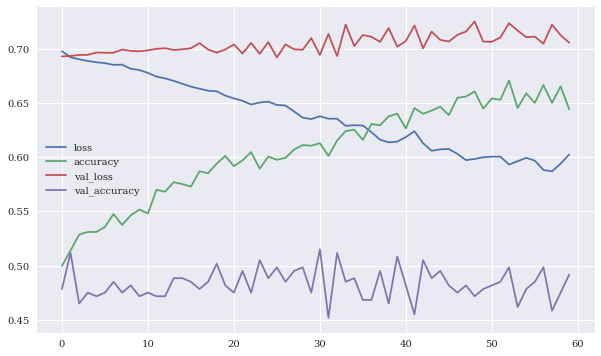

In [25]:
res.plot(figsize=(10, 6));

In [26]:
model.evaluate(np.atleast_3d(test[cols]), test['d'])

16/16 [==============================] - 0s 2ms/step - loss: 0.7243 - accuracy: 0.5030


[0.7243193984031677, 0.5030060410499573]

In [27]:
test['p'] = np.where(model.predict(np.atleast_3d(test[cols])) > 0.5, 1, 0)

In [28]:
test['p'] = np.where(test['p'] > 0, 1, -1)

In [29]:
test['p'].value_counts()

-1    317
 1    182
Name: p, dtype: int64

In [30]:
(test['p'].diff() != 0).sum()

225

In [31]:
test['s'] = test['p'] * test['r']

In [32]:
ptc = 0.00012 / test[symbol]

In [33]:
test['s_'] = np.where(test['p'] != 0, test['s'] - ptc, test['s'])

In [38]:
test[['r', 's', 's_']]

,r,s,s_
Date,,,
2018-01-08,-0.005252,0.005252,0.005151
2018-01-09,-0.002510,0.002510,0.002410
2018-01-10,0.000838,0.000838,0.000737
2018-01-11,0.007174,-0.007174,-0.007274
2018-01-12,0.012719,0.012719,0.012621
...,...,...,...
2019-12-24,0.000090,-0.000090,-0.000198
2019-12-26,0.000811,-0.000811,-0.000920
2019-12-27,0.007094,-0.007094,-0.007202


In [34]:
test[['r', 's', 's_']].sum().apply(np.exp)

r     0.931992
s     1.147129
s_    1.088831
dtype: float64

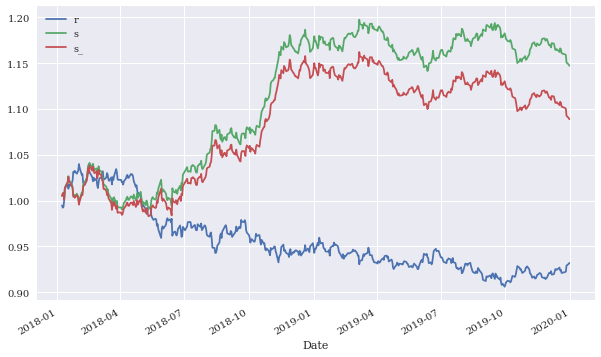

In [39]:
test[['r', 's', 's_']].cumsum().apply(np.exp).plot(figsize=(10, 6));